In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [32]:
%%writefile ./scripts/download.py
import yfinance as yf
import pandas as pd
import datetime

def download1mdata(symbol):
    today = datetime.datetime.now()
    filewritingdate = today.strftime('%y') + today.strftime('%m') + today.strftime('%d')

    data = yf.download(
        tickers=symbol,
        period='max',
        interval='1m'
    )
    data = pd.DataFrame(data)

    pd.DataFrame.to_csv(data, f'./data/downloaded/{symbol}_{filewritingdate}_1m.csv', sep=',')
    print(f'Saved {symbol} 1 minute interval data.')


Overwriting ./scripts/download.py


In [33]:
%%writefile -a ./scripts/download.py
import yfinance as yf
import pandas as pd
import datetime

def download5mdata(symbol):
    today = datetime.datetime.now()
    startdate = today - datetime.timedelta(days=30)
    filewritingdate = today.strftime('%y') + today.strftime('%m') + today.strftime('%d')

    data = yf.download(
        tickers=symbol,
        start=f"{startdate.strftime('%Y')}-{startdate.strftime('%m')}-{startdate.strftime('%d')}",
        end=f"{today.strftime('%Y')}-{today.strftime('%m')}-{today.strftime('%d')}",
        interval='5m'
    )
    data = pd.DataFrame(data)

    pd.DataFrame.to_csv(data, f'./data/downloaded/{symbol}_{filewritingdate}_5m.csv', sep=',')
    print(f'Saved {symbol} 5 minute interval data.')

Appending to ./scripts/download.py


In [46]:
%%writefile -a ./scripts/download.py
def updateShortPeriodData():
  target_company = pd.read_csv('./data/target_company.csv', sep=',')
  print('Downloading all listed data')
  for i in range(len(target_company)):
      sb = target_company['Symbol'][i]
      download5mdata(sb)
      download1mdata(sb)
  print('Done')


Appending to ./scripts/download.py


In [ ]:
from scripts import download

download.updateShortPeriodData()

In [2]:
import yfinance as yf
import pandas as pd

data = yf.download('TSLA', start='2023-02-09', end='2023-03-09', interval='5m')
data = pd.DataFrame(data)

[*********************100%***********************]  1 of 1 completed


In [3]:
data

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-02-09 09:30:00-05:00,207.774994,208.119995,205.530106,207.130005,207.130005,15803741
2023-02-09 09:35:00-05:00,207.139999,208.630005,206.592606,208.577805,208.577805,5209095
2023-02-09 09:40:00-05:00,208.561996,208.789993,205.910004,206.589996,206.589996,5427561
2023-02-09 09:45:00-05:00,206.580002,207.830002,206.389999,207.449997,207.449997,3494435
2023-02-09 09:50:00-05:00,207.420395,208.130005,206.830002,207.659302,207.659302,3503319
...,...,...,...,...,...,...
2023-03-08 15:35:00-05:00,180.809998,181.740005,180.710007,181.449997,181.449997,2110135
2023-03-08 15:40:00-05:00,181.449997,182.119995,181.402100,182.022003,182.022003,1811315
2023-03-08 15:45:00-05:00,182.039993,182.389999,181.820007,181.970001,181.970001,1993728


In [122]:
%%writefile -a ./scripts/assets.py
from pathlib import Path
import glob
import pandas as pd
import datetime

class Equity():
    '''
    Equity class has its own history and properties for deciding to open or close positions of a specific stock.

    - parameters
    symbol: (ticker) alphabet abbreviation for a specific stock
    threshold: minimum percentage of value change to decide buy or sell
    duration: minimum duration of consistency of value change to decide buy or sell
    rebound: gradient of change as a trigger of action
    limit: maximum amount of total value per action
    '''
    def __init__(
        self,
        symbol: str,
        threshold: float = 0.1,
        duration: int = 2,
        rebound: float = 0,
        limit: int = 1000,
    ) -> None:
        if not (0.02 <= threshold <= 1):
            threshold = 0.1
        if duration <= 0:
            duration = 2
        self.symbol = symbol
        self.thr_buy = threshold
        self.thr_sell = threshold
        self.dur = duration
        self.reb = rebound
        self.limit = limit

    def __repr__(self) -> str:
        return f'symbol: {self.symbol}, thresholds: {self.thr_buy, self.thr_sell}, duration: {self.dur}, rebound: {self.reb}, limit: {self.limit}.'

    def load(
        self,
        path: Path or str
    ) -> None:
        '''
        load settings of a specific stock from given path
        if multiple settings exist, load the most recent one

        - parameters
        path: relative or absolute path of source folder
        '''
        if isinstance(path, str):
            path = Path(path)

        recent_docs = glob.glob(str(path) + '/' + self.symbol + '_*_settings.csv')
        if recent_docs:
            setting = pd.read_csv(recent_docs[-1], sep=',')
            self.thr_buy = setting['thr_buy'].iloc[-1]
            self.thr_sell = setting['thr_sell'].iloc[-1]
            self.dur = setting['duration'].iloc[-1]
            self.reb = setting['rebound'].iloc[-1]
            self.limit = setting['limit'].iloc[-1]

    def save(
        self,
        path: Path or str
    ) -> None:
        '''
        save settings of a specific stock to given path
        saved date is recorded at file name

        - parameters
        path: relative or absolute path of target folder
        '''
        if isinstance(path, str):
            path = Path(path)

        today = datetime.datetime.now()
        filewritingdate = today.strftime('%y') + today.strftime('%m') + today.strftime('%d')

        new_setting = pd.DataFrame(
            [[self.thr_buy, self.thr_sell, self.dur, self.reb, self.limit]],
            columns=['thr_buy', 'thr_sell', 'duration', 'rebound', 'limit']
        )

        prev_docs = glob.glob(str(path) + '/' + self.symbol + f'_{filewritingdate}_settings.csv')

        if prev_docs:
            setting = pd.read_csv(prev_docs[-1], sep=',')
            new_setting = setting.append(new_setting)

        new_setting.to_csv(str(path) + '/' + self.symbol + f'_{filewritingdate}_settings.csv', sep=',')


Appending to ./scripts/trading.py


In [9]:
from scripts import assets

# tsla = assets.Equity('TSLA', threshold=0.03, duration=1, thr_grad=0.01)
tsla = assets.Equity('TSLA')
print(tsla)

symbol: TSLA, thresholds: (0.1, 0.1), duration: 2, gradient_threshold: 0.02, rebound: 0, limit: 1000.


In [8]:
tsla.save('./data/setting_data')

   thr_buy  thr_sell  duration  thr_grad  rebound  limit
0     0.03      0.03         1      0.01        0   1000
   thr_buy  thr_sell  duration  thr_grad  rebound  limit
0      0.1       0.1         2      0.02        0   1000


In [12]:
tsla.load('./data/setting_data')
print(tsla)

symbol: TSLA, thresholds: (0.03, 0.03), duration: 1, gradient_threshold: 0.01, rebound: 0, limit: 1000.


In [27]:
ts_data = np.array(data.Open)
buying_points = []
selling_points = []
almost_points = []
tsla = assets.Equity('TSLA', threshold=0.03, duration=1, thr_grad=0.01)
start_time = 0
for i in range(1, len(ts_data)):
    buy_diff_thr = ts_data[start_time] * tsla.thr_buy
    sell_diff_thr = ts_data[start_time] * tsla.thr_sell
    bool_diff = ts_data[start_time] - buy_diff_thr > ts_data[i] or ts_data[start_time] + sell_diff_thr < ts_data[i]
    bool_dur = (i - start_time) / 12 >= tsla.dur
    bool_grad = abs(ts_data[start_time] - ts_data[i]) / (i - start_time) * 12 > ts_data[start_time] * tsla.thr_grad

    if bool_diff and bool_dur and bool_grad:
        almost_points.append(i)
        print(i, (ts_data[i] - ts_data[i - 2]), ts_data[start_time], (ts_data[i] - ts_data[i - 2]) / ts_data[start_time])
        if ts_data[i] < ts_data[start_time]:
            bool_rebound = -0.005 + tsla.reb < (ts_data[i] - ts_data[i - 2]) / ts_data[start_time]
            if bool_rebound:
                buying_points.append((i, ts_data[i]))
                start_time = i
        else:
            bool_rebound = (ts_data[i] - ts_data[i - 2]) / ts_data[start_time] < 0.005 + tsla.reb
            if bool_rebound:
                selling_points.append((i, ts_data[i]))
                start_time = i

    if (i - start_time) / 12 >= tsla.dur * 2 and not bool_grad:
        start_time = i

85 -2.3739013671875 212.0500030517578 -0.01119500746532916
86 -2.204986572265625 212.0500030517578 -0.010398427448866506
157 -5.8079986572265625 197.1999969482422 -0.029452326303792745
158 -3.54998779296875 197.1999969482422 -0.01800196677437319
161 -3.2649993896484375 197.1999969482422 -0.016556792292980516
162 -1.70001220703125 197.1999969482422 -0.008620751690363571
163 0.572998046875 197.1999969482422 0.0029056696538661262
172 3.6100006103515625 189.6929931640625 0.019030753588401284
462 -2.2740936279296875 211.77609252929688 -0.01073819806933633
463 -2.64190673828125 211.77609252929688 -0.012474999924345906
464 -0.6399993896484375 211.77609252929688 -0.0030220568431722325
722 -1.175201416015625 203.57249450683594 -0.005772889008717049
723 -1.5399932861328125 203.57249450683594 -0.007564839689485161
859 6.9499969482421875 197.2100067138672 0.0352416039330396
860 1.8600006103515625 197.2100067138672 0.009431573181021414
861 0.774993896484375 197.2100067138672 0.003929789919883816
10

<IPython.core.display.Javascript object>


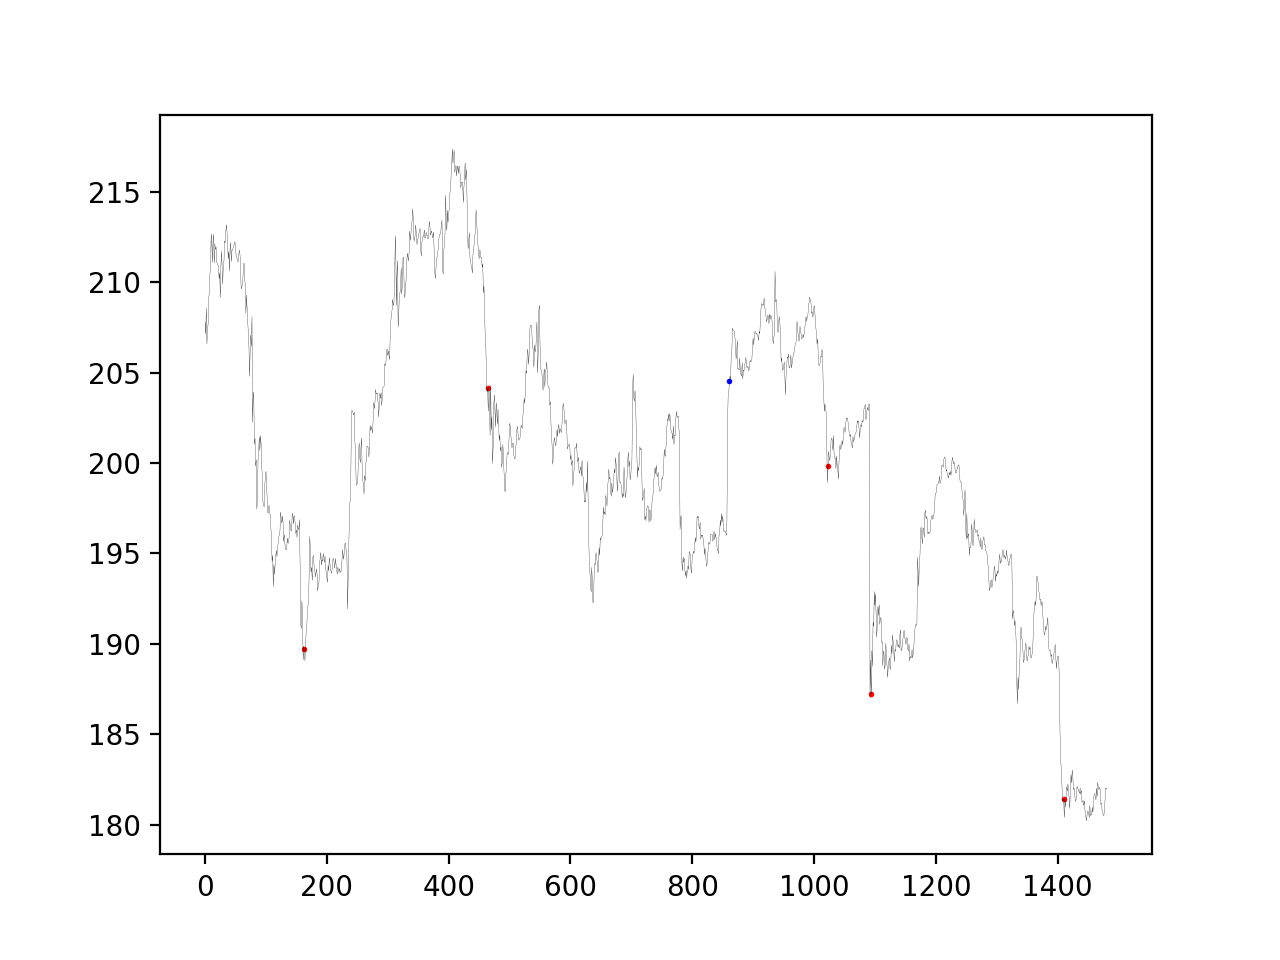

In [28]:
%matplotlib notebook

plt.plot(ts_data, color='black', linewidth=0.1)
plt.scatter([x[0] for x in buying_points], [x[1] for x in buying_points], s=1, c='red')
plt.scatter([x[0] for x in selling_points], [x[1] for x in selling_points], s=1, c='blue')